<a href="https://colab.research.google.com/github/paulohenrique1303/Neural-Network/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn import datasets

In [11]:
plt.rcParams['figure.figsize'] = (6,4)
plt.style.use('dark_background')

##Classe Perceptron

In [12]:
class Perceptron:
    def __init__(self, input_size, learning_rate = 0.01, epochs= 1000):
        self.weights= np.zeros(input_size + 1)
        self.learning_rate= learning_rate
        self.epochs = epochs

    def train(self, X, y):
        for epochs in range(self.epochs):
            for i in range(len(X)):
                prediction = self.predict(X[i])
                error = y[i] - prediction

                self.weights[1:] += self.learning_rate * error * X[i]
                self.weigths[0] += self.learning_rate * error

    def predict(self, x):
        z = np.dot(x, self.weights[1:]) + self.weigths[0]

        return 1 if z > 0 else 0

## Classe Rede Neural

In [13]:
class NeuralNetwork:
    def __init__(self, x: np.ndarray, y: np.ndarray, hidden_neurons: int= 3, output: int= 2):

        np.random.seed(69)

        self.x = x
        self.y = y
        self.hidden_neurons = hidden_neurons
        self.output = output
        self.input_neurons = self.x.shape[1]

        # Inicializando os pesos e bias.
        # Xavier Inicialization para garantir a variança dos pesos em todas as camadas.

        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)
        self.B1 = np.zeros((1, self.hidden_neurons))
        self.W2 = np.random.randn(self.hidden_neurons, self.output) / np.sqrt(self.hidden_neurons)
        self.B2 = np.zeros((1, self.output))

        self.dict = {'W1': self.W1,
                     'B1': self.B1,
                     'W2': self.W2,
                     'B2': self.B2}

        self.z1 = 0
        self.f1 = 0
    def foward(self, x: np.ndarray):
        # Equação da reta
        # z1 = W1 * x + B1
        self.z1 = np.dot(x, self.W1) + self.B1

        # Primeira função de ativação
        # Vou utilizar a tangente hiperbolica
        self.f1 = np.tanh(self.z1)

        # Segunda equação da reta
        z2 = np.dot(self.f1, self.W2) + self.B2

        # Por ultimo vamos definar a função de ativação dos neuronios de saída
        # Como temos um problema de classificação multiclasse, vou etsar usando a softmax
        exp_scores = np.exp(z2)
        softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return softmax

    def loss(self, softmax: np.ndarray):
        #Como o problema é de classificação multiclasse vou estar utilizamdo como função de perda Cross Entropy
        predictions = np.zeros(self.y.shape[0])
        for i, correct_index in enumerate(self.y):
            predicted = softmax[i][correct_index]
            predictions[i] = predicted

        log_prob = -np.log(predicted)
        return log_prob / self.y.shape[0]

    def backpropagation(self, softmax: np.ndarray, learning_rate: float) -> None:
        #Copia da softmax para não alterar o valor da variável original
        delta2 = np.copy(softmax)

        # Subtrai 1 da posição correspondente à classe correta nos resultados da softmax
        # Isso equivale ao cálculo do gradiente do erro da função de perda cross-entropy com softmax
        delta2[range(self.x.shape[0]), self.y] -= 1

        # Calcula o gradiente dos pesos da segunda camada (camada de saída)
        dW2 = np.dot(self.f1.T, delta2)  # f1 é a saída da primeira camada (camada oculta)

        # Calcula o gradiente dos vieses da segunda camada
        dB2 = np.sum(delta2, axis=0, keepdims=True)

        # Calcula o erro propagado para a camada anterior (camada oculta)
        # Multiplica pelo derivado da função de ativação
        delta1 = np.dot(delta2, self.W2.T) * (1 - np.power(self.f1, 2))

        # Gradiente dos pesos da primeira camada (entrada para camada oculta)
        dW1 = np.dot(self.x.T, delta1)

        # Gradiente dos vieses da primeira camada
        dB1 = np.sum(delta1, axis=0, keepdims=True)

        # Atualização dos pesos e baias com base nos gradientes e na taxa de aprendizado
        self.W1 -= learning_rate * dW1
        self.B1 -= learning_rate * dB1
        self.W2 -= learning_rate * dW2
        self.B2 -= learning_rate * dB2

    def show_plot(self, x: np.ndarray, predictions: np.ndarray) -> None:
        if x.shape[1] == 2:
            plt.scatter(x[:,0], x[:,1], c= predictions, s= 50, alpha = 0.5, cmap = 'cool')
            plt.show()
        elif x.shape[1] == 3:
            ax = plt.axes(projection='3d')
            ax.scatter3D(x[:,0], x[:,1], x[:,2], c= predictions, s= 50, alpha = 0.5, cmap = 'cool')
            plt.show()



    def fit(self, epochs: int, learning_rate: float, show_plot: bool = False) -> np.ndarray:
        for epoch in range(epochs):
            softmax = self.foward(self.x)
            loss = self.loss(softmax)
            self.backpropagation(softmax, learning_rate)

            #Acurácia
            predictions = np.argmax(softmax, axis=1)
            correct = (predictions == self.y).sum()
            accuracy = correct / self.y.shape[0]

            if int((epoch + 1) % (epochs / 10)) == 0: #imprime na tela os dados de 10 epocas,
                print(f'Epoch: {epoch + 1} / {epochs}, Accuracy: {accuracy:.3f}, Loss: {loss.item():.4f}')
                if show_plot:
                    self.show_plot(self.x, predictions)

        return predictions

    def predict(self, x: np.ndarray, y: np.ndarray, show_plot: bool= False) -> np.ndarray:
        softmax = self.foward(x)
        #Acurácia
        predictions = np.argmax(softmax, axis=1)
        correct = (predictions == y).sum()
        accuracy = correct / y.shape[0]
        print(f'Accuracy: {accuracy:.3f}')
        if show_plot:
            self.show_plot(x, predictions)
        return predictions

    def save(self, path: str) -> None:
        with open(path, 'wb') as file:
            pickle.dump(self.dict, file)

## Modelos aplicados a 2 Features (2d) e N Classes



Para primeiro teste do modelo vou testar um dataset fictício de 2 features e 4 classes

In [14]:
qtd_dados = 300
noise = 2
n_classes = 4

In [15]:
x, y = datasets.make_blobs(n_samples=qtd_dados, centers= n_classes, n_features= 2, cluster_std= noise, random_state= 42)
print(f'{x.shape = }\n{y.shape = }')

x.shape = (300, 2)
y.shape = (300,)


In [16]:
qtd_treino = int(0.8 * qtd_dados)
qtd_teste = int(0.2 * qtd_dados)
qtd_treino, qtd_teste

(240, 60)

In [17]:
x_train = x[:qtd_treino]
y_train = y[:qtd_treino]
x_test = x[qtd_treino:]
y_test = y[qtd_treino:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((240, 2), (240,), (60, 2), (60,))

Text(0.5, 1.0, 'Todos os dados e suas classificações ')

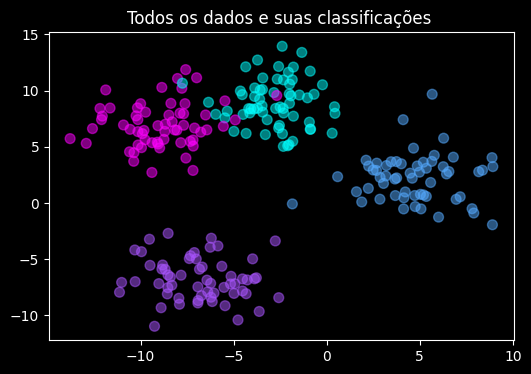

In [18]:
plt.scatter(x_train[:,0], x_train[:,1], c= y_train, s= 50, alpha = 0.5, cmap = 'cool' )
plt.title('Todos os dados e suas classificações ')

In [19]:
hidden_neurons = 10
output_neurons = n_classes
epochs = 100
learning_rate = 0.015

Epoch: 10 / 100, Accuracy: 0.738, Loss: 0.0364


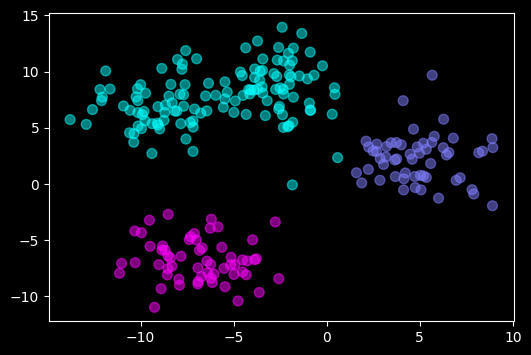

Epoch: 20 / 100, Accuracy: 0.946, Loss: 0.0000


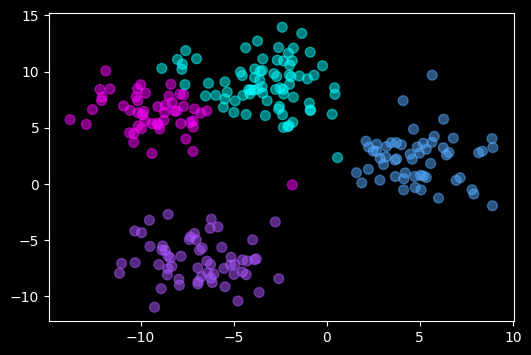

Epoch: 30 / 100, Accuracy: 0.946, Loss: 0.0000


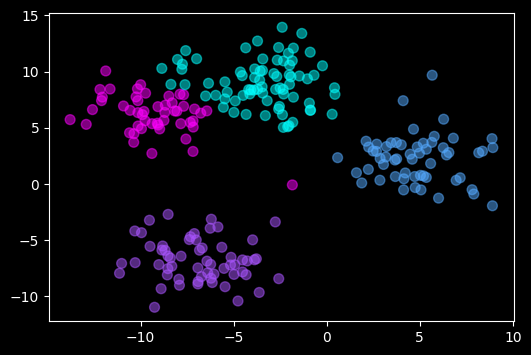

Epoch: 40 / 100, Accuracy: 0.950, Loss: 0.0000


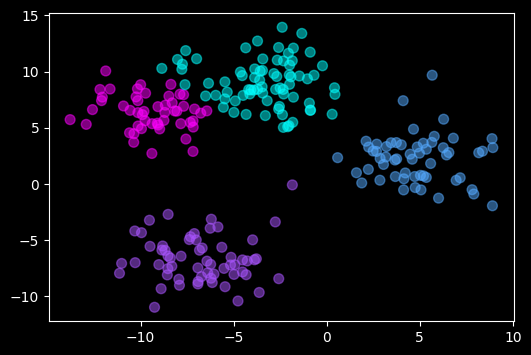

Epoch: 50 / 100, Accuracy: 0.929, Loss: 0.0000


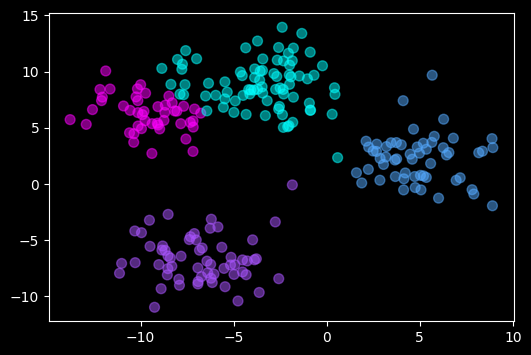

Epoch: 60 / 100, Accuracy: 0.963, Loss: 0.0000


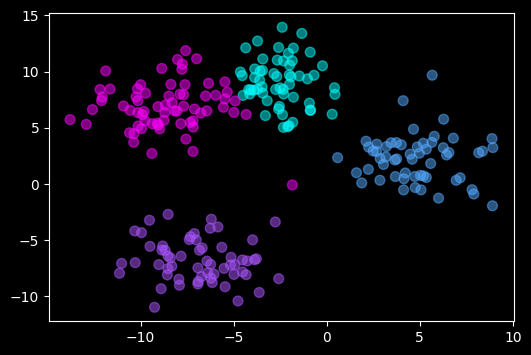

Epoch: 70 / 100, Accuracy: 0.958, Loss: 0.0000


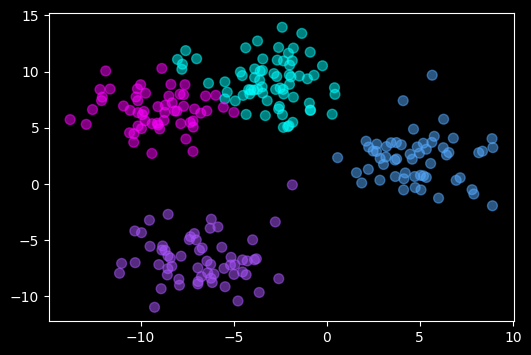

Epoch: 80 / 100, Accuracy: 0.967, Loss: 0.0000


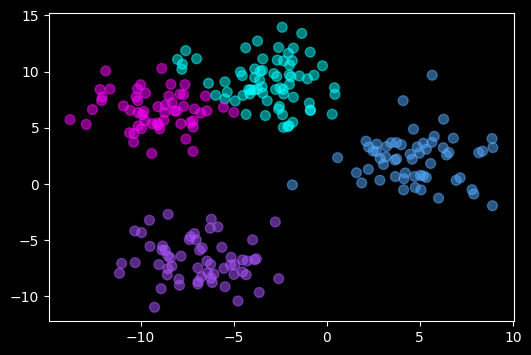

Epoch: 90 / 100, Accuracy: 0.967, Loss: 0.0000


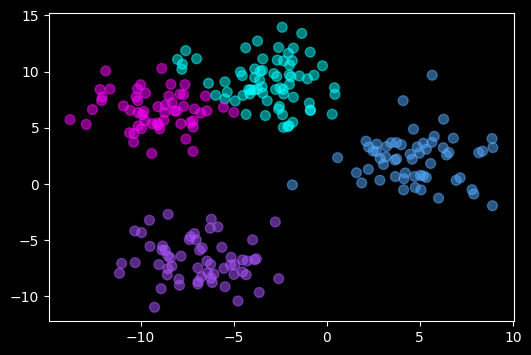

Epoch: 100 / 100, Accuracy: 0.967, Loss: 0.0000


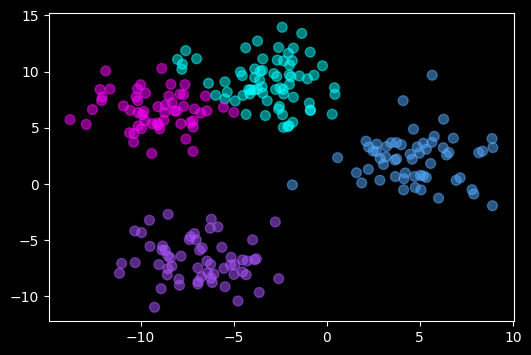

In [20]:
model = NeuralNetwork(x_train, y_train, hidden_neurons, output_neurons)
previsoes_treinamento = model.fit(epochs, learning_rate,show_plot= True)

Accuracy: 0.950


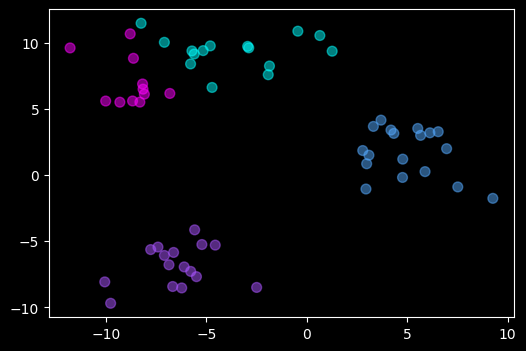

array([0, 2, 2, 1, 0, 2, 2, 2, 3, 2, 3, 2, 3, 1, 2, 3, 1, 0, 3, 0, 1, 0,
       3, 0, 2, 1, 2, 1, 1, 0, 0, 2, 1, 1, 3, 3, 2, 0, 0, 1, 1, 1, 1, 2,
       3, 1, 2, 1, 1, 2, 0, 2, 1, 0, 3, 0, 1, 0, 3, 0])

In [21]:
 model.predict(x_test, y_test, show_plot= True)

Text(0.5, 1.0, 'Valores reais de Teste')

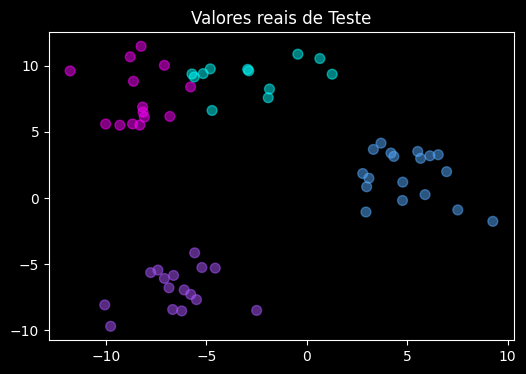

In [22]:
plt.scatter(x_test[:,0], x_test[:,1], c= y_test, s= 50, alpha = 0.5, cmap = 'cool' )
plt.title('Valores reais de Teste')

In [23]:
model.save('model.pkl')

Para segundo teste do modelo vou manter com 2 features porém vou gerar outro dataset com padrões de classificações em "semi luas"

In [24]:
qtd_dados = 500
noise = 0.1
n_classes = 2

In [25]:
x , y = datasets.make_moons(n_samples= qtd_dados, noise= noise)
print(f'{x.shape = }\n{y.shape = }')

x.shape = (500, 2)
y.shape = (500,)


In [26]:
qtd_treino = int(0.8 * qtd_dados)
qtd_teste = int(0.2 * qtd_dados)
qtd_treino, qtd_teste

(400, 100)

In [27]:
x_train = x[:qtd_treino]
y_train = y[:qtd_treino]
x_test = x[qtd_treino:]
y_test = y[qtd_treino:]

Text(0.5, 1.0, 'Dados de treino e suas classificações ')

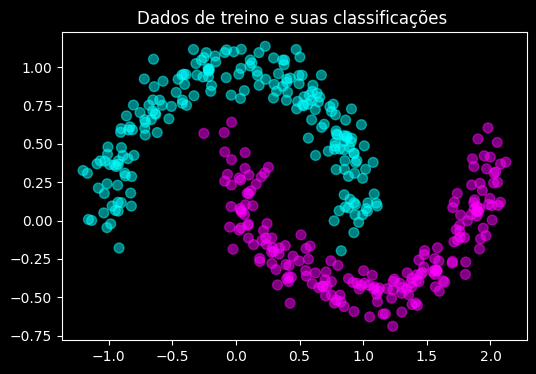

In [28]:
plt.scatter(x_train[:,0], x_train[:,1], c= y_train, s= 50, alpha = 0.5, cmap = 'cool' )
plt.title('Dados de treino e suas classificações ')

Epoch: 10 / 100, Accuracy: 0.785, Loss: 0.0000


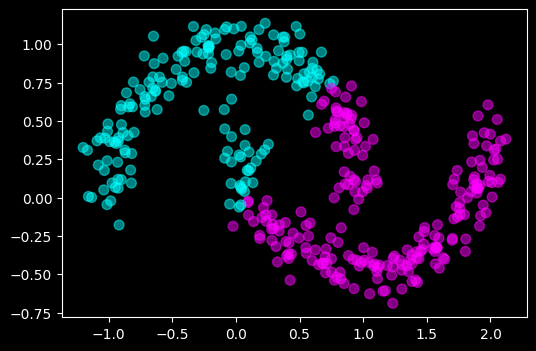

Epoch: 20 / 100, Accuracy: 0.855, Loss: 0.0000


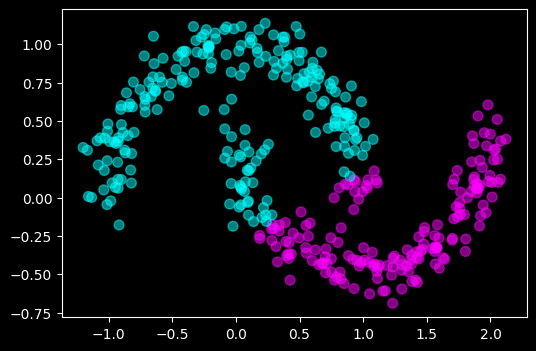

Epoch: 30 / 100, Accuracy: 0.973, Loss: 0.0000


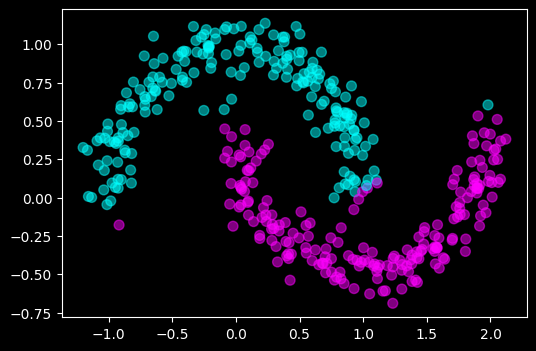

Epoch: 40 / 100, Accuracy: 0.985, Loss: 0.0001


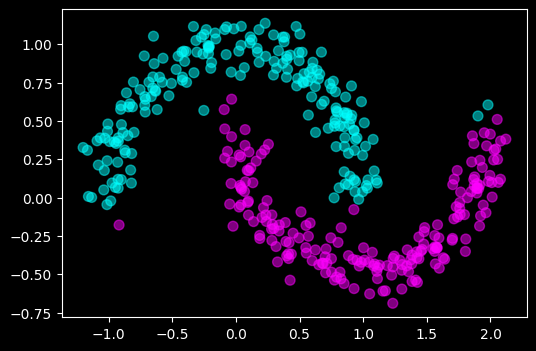

Epoch: 50 / 100, Accuracy: 0.995, Loss: 0.0001


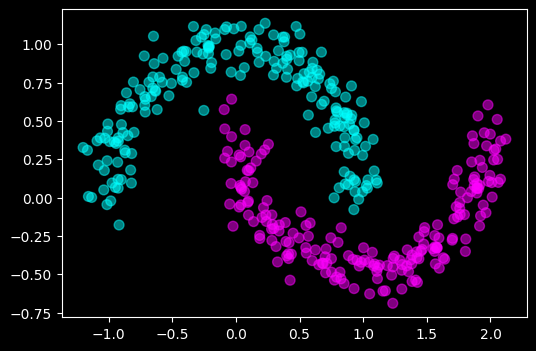

Epoch: 60 / 100, Accuracy: 0.995, Loss: 0.0001


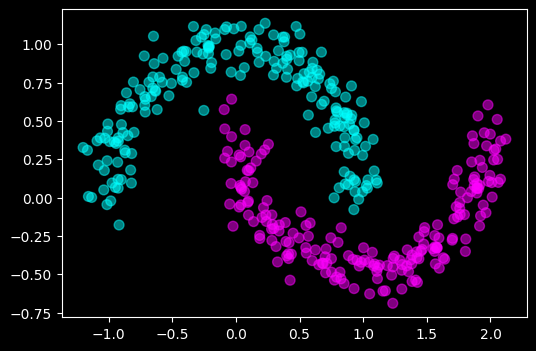

Epoch: 70 / 100, Accuracy: 0.998, Loss: 0.0000


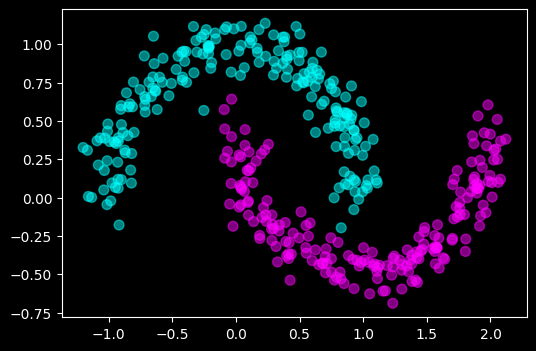

Epoch: 80 / 100, Accuracy: 0.998, Loss: 0.0000


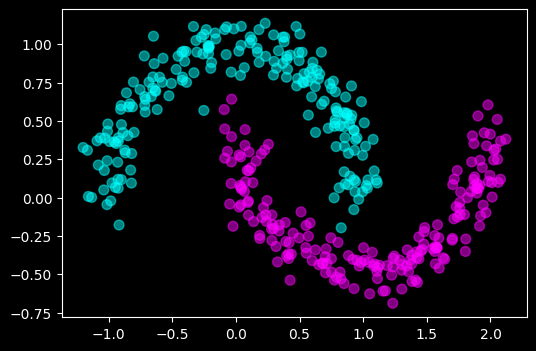

Epoch: 90 / 100, Accuracy: 0.998, Loss: 0.0000


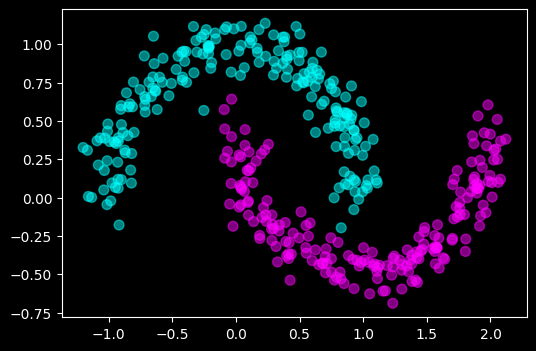

Epoch: 100 / 100, Accuracy: 1.000, Loss: 0.0000


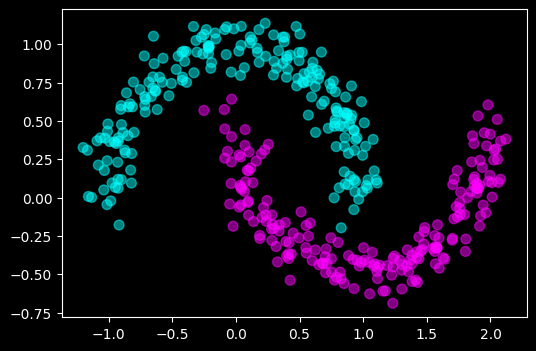

In [29]:
model = NeuralNetwork(x_train, y_train, hidden_neurons, output_neurons)
previsoes_treinamento = model.fit(epochs, learning_rate, show_plot = True)

Accuracy: 1.000


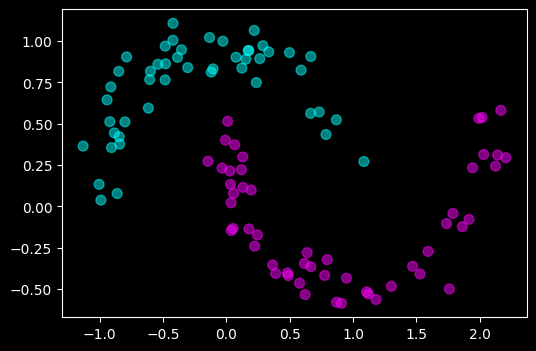

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0])

In [30]:
model.predict(x_test, y_test, show_plot= True)

Text(0.5, 1.0, 'Valores reais de Teste')

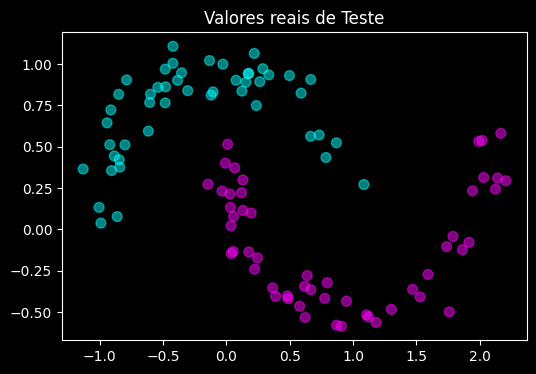

In [31]:
plt.scatter(x_test[:,0], x_test[:,1], c= y_test, s= 50, alpha = 0.5, cmap = 'cool' )
plt.title('Valores reais de Teste')

Para ultimo teste de 2 features, vou testar com padrões de classificações circulares

In [32]:
n_samples = 500
noise = 0.1
n_classes = 2

In [33]:
x, y = datasets.make_circles(n_samples=qtd_dados, noise=noise, factor=0.5)
print(f'{x.shape = }\n{y.shape = }')

x.shape = (500, 2)
y.shape = (500,)


In [34]:
qtd_treino = int(0.8 * qtd_dados)
qtd_teste = int(0.2 * qtd_dados)
qtd_treino, qtd_teste

(400, 100)

In [35]:
x_train = x[:qtd_treino]
y_train = y[:qtd_treino]
x_test = x[qtd_treino:]
y_test = y[qtd_treino:]

Text(0.5, 1.0, 'Dados de treino e suas classificações ')

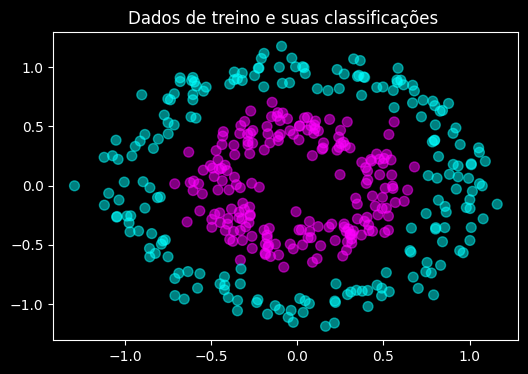

In [36]:
plt.scatter(x_train[:,0], x_train[:,1], c= y_train, s= 50, alpha = 0.5, cmap = 'cool' )
plt.title('Dados de treino e suas classificações ')

In [37]:
hidden_neurons = 10
output_neurons = n_classes
epochs = 200
learning_rate = 0.02

Epoch: 20 / 200, Accuracy: 0.495, Loss: 0.0749


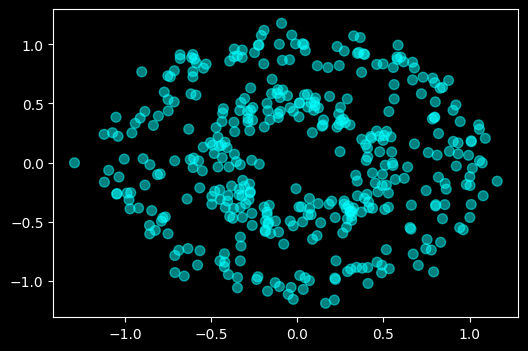

Epoch: 40 / 200, Accuracy: 0.512, Loss: 0.1225


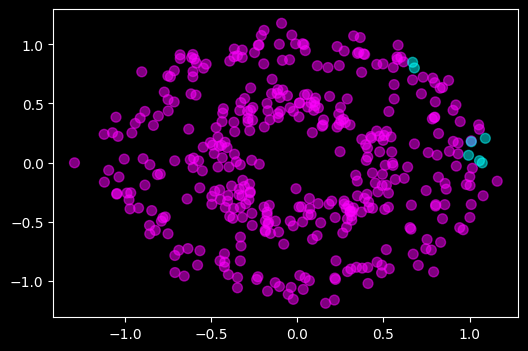

Epoch: 60 / 200, Accuracy: 0.547, Loss: 0.1291


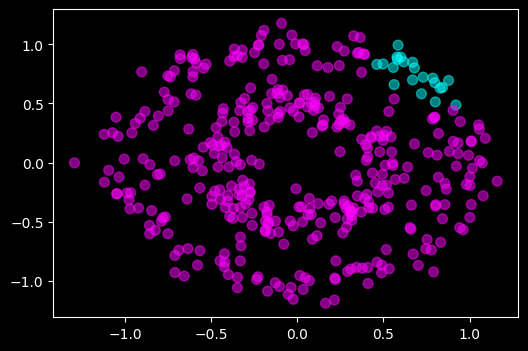

Epoch: 80 / 200, Accuracy: 0.502, Loss: 0.1567


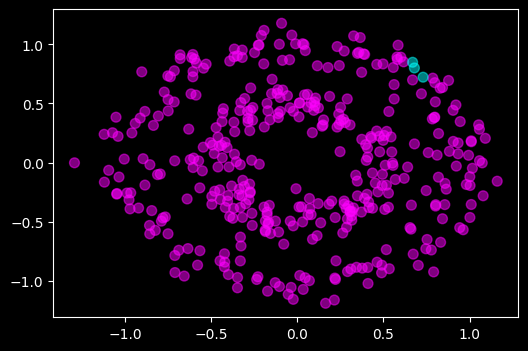

Epoch: 100 / 200, Accuracy: 0.777, Loss: 0.0000


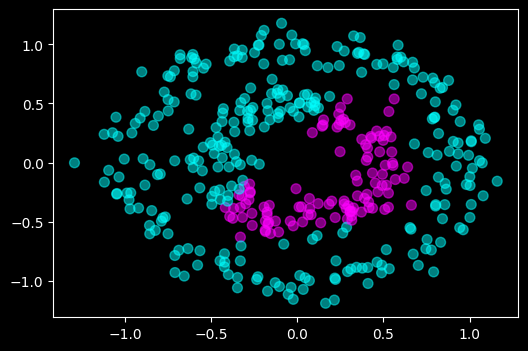

Epoch: 120 / 200, Accuracy: 0.940, Loss: 0.0000


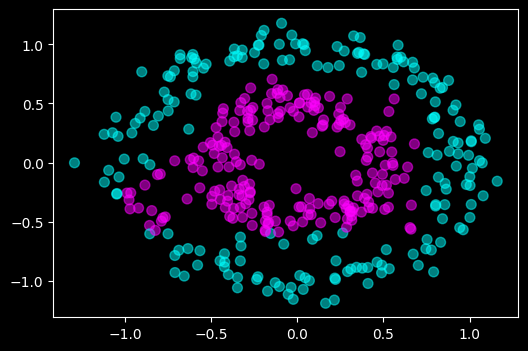

Epoch: 140 / 200, Accuracy: 0.958, Loss: 0.0000


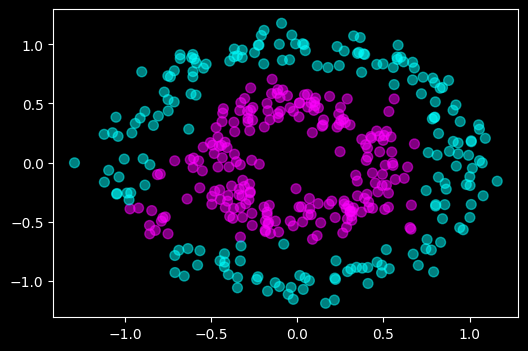

Epoch: 160 / 200, Accuracy: 0.995, Loss: 0.0000


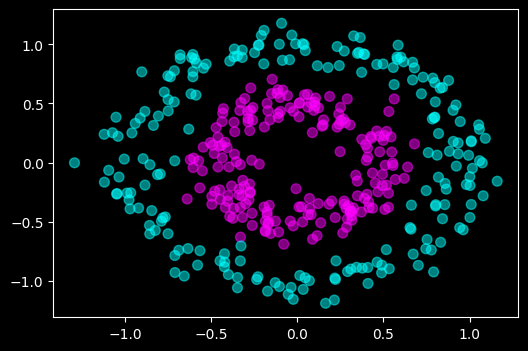

Epoch: 180 / 200, Accuracy: 0.998, Loss: 0.0000


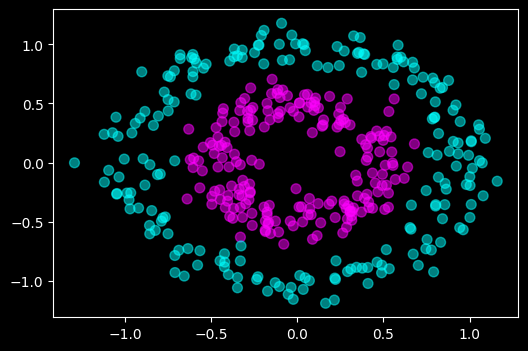

Epoch: 200 / 200, Accuracy: 1.000, Loss: 0.0000


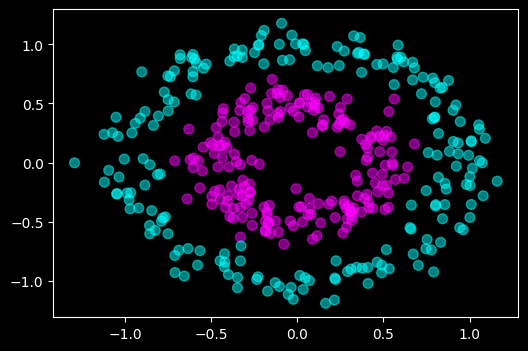

In [38]:
model = NeuralNetwork(x_train, y_train, hidden_neurons, output_neurons)
previsoes_treinamento = model.fit(epochs, learning_rate, show_plot = True)

Accuracy: 0.980


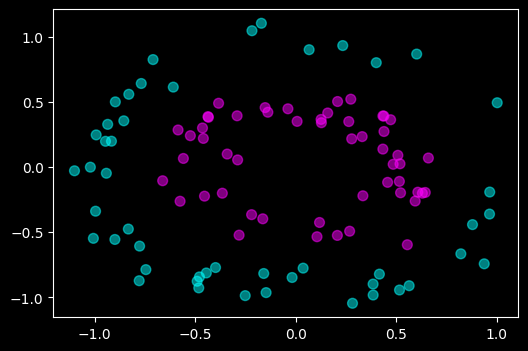

In [39]:
previsoes = model.predict(x_test, y_test, show_plot= True)

Text(0.5, 1.0, 'Valores reais de Teste')

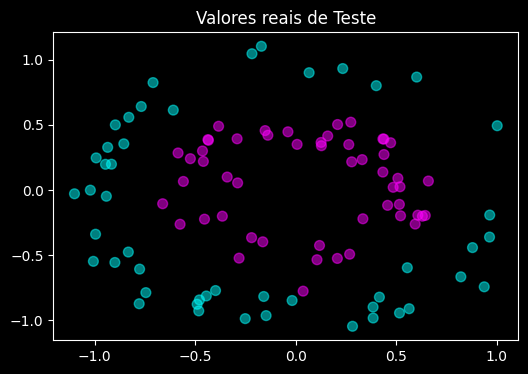

In [40]:
plt.scatter(x_test[:,0], x_test[:,1], c= y_test, s= 50, alpha = 0.5, cmap = 'cool' )
plt.title('Valores reais de Teste')

# Modelo aplicado a 3 Features (3d) e N Classes

In [41]:
qtd_dados = 500
noise = 1.2
n_classes = 4
n_features = 3

In [42]:
# gerar dados de 3 features e n classes
x, y = datasets.make_blobs(n_samples=qtd_dados, centers= n_classes, n_features= 3, cluster_std= noise, random_state= 42)
print(f'{x.shape = }\n{y.shape = }')

x.shape = (500, 3)
y.shape = (500,)


In [43]:
qtd_treino = int(0.8 * qtd_dados)
qtd_teste = int(0.2 * qtd_dados)
qtd_treino, qtd_teste

(400, 100)

In [44]:
x_train = x[:qtd_treino]
y_train = y[:qtd_treino]
x_test = x[qtd_treino:]
y_test = y[qtd_treino:]

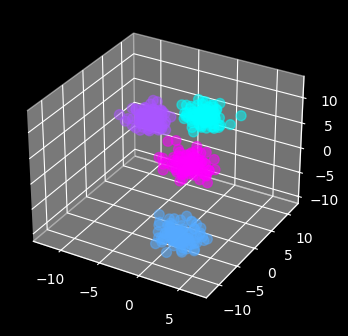

In [45]:
# Visualizar os dados de treino
ax = plt.axes(projection='3d')
ax.scatter3D(x_train[:,0], x_train[:,1], x_train[:,2], c= y_train, s= 50, alpha = 0.5, cmap = 'cool' )

In [46]:
hidden_neurons = 5
output_neurons = n_classes
epochs = 700
learning_rate = 0.01

Epoch: 70 / 700, Accuracy: 0.490, Loss: 0.0078


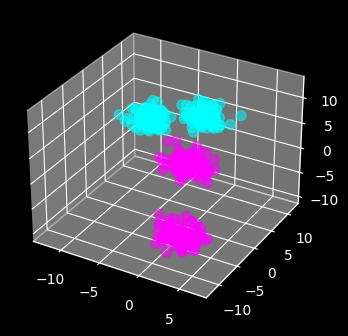

Epoch: 140 / 700, Accuracy: 0.490, Loss: 0.0078


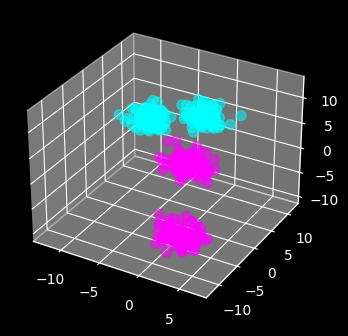

Epoch: 210 / 700, Accuracy: 0.490, Loss: 0.0077


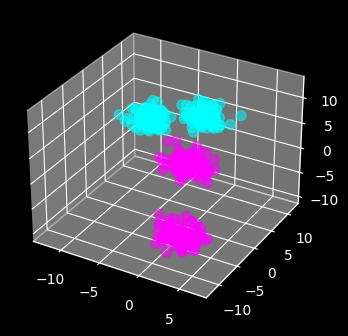

Epoch: 280 / 700, Accuracy: 0.490, Loss: 0.0077


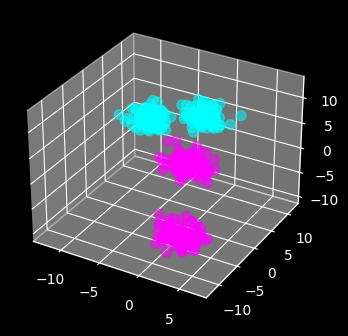

Epoch: 350 / 700, Accuracy: 0.490, Loss: 0.0077


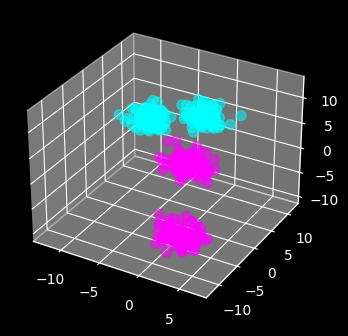

Epoch: 420 / 700, Accuracy: 0.490, Loss: 0.0077


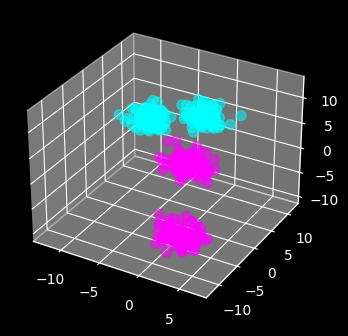

Epoch: 490 / 700, Accuracy: 0.998, Loss: 0.0000


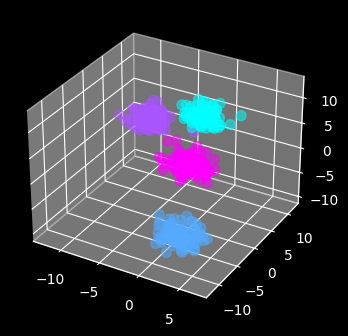

Epoch: 560 / 700, Accuracy: 0.998, Loss: 0.0000


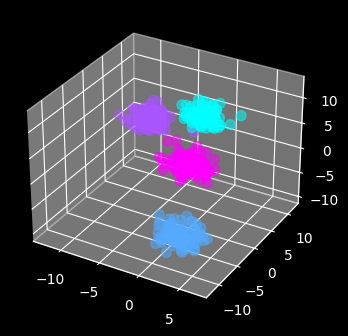

Epoch: 630 / 700, Accuracy: 0.998, Loss: 0.0000


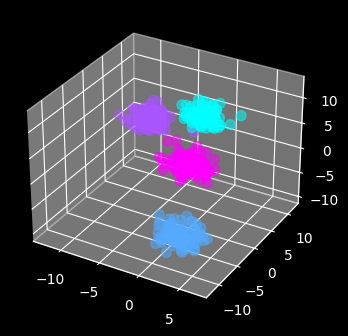

Epoch: 700 / 700, Accuracy: 0.998, Loss: 0.0000


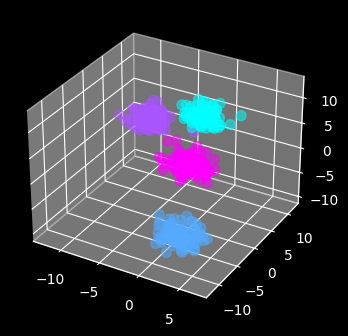

In [47]:
model = NeuralNetwork(x_train, y_train, hidden_neurons, output_neurons)
previsoes_treinamento = model.fit(epochs, learning_rate, show_plot = True)

Accuracy: 1.000


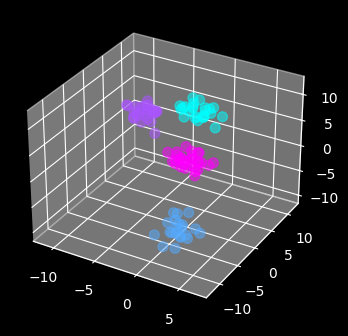

In [48]:
previsoes = model.predict(x_test, y_test, show_plot= True)

Text(0.5, 0.92, 'Valores reais de Teste')

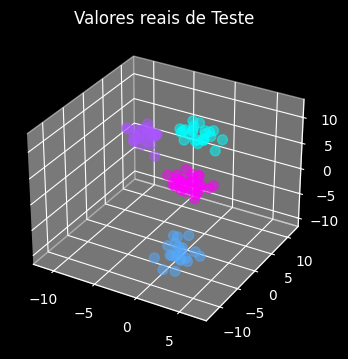

In [49]:
ax = plt.axes(projection='3d')
ax.scatter3D(x_test[:,0], x_test[:,1], x_test[:,2], c= y_test, s= 50, alpha = 0.5, cmap = 'cool' )
plt.title('Valores reais de Teste')